In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from implemented_functions_to_use.helper_functions import set_seeds
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Configure Model Parameters
class PARAM:
    EPOCHS = 30
    BATCH_SIZE = 32
    P = 0.5 #probability for Data Augmentation
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_MEAN = [0.456]     #for Data Augmentation
    IMAGE_STD_DEVIATION = [0.224]     #for Data Augmentation
    PROB = 0.5
    WEIGHT_DECAY = 0.01

In [4]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# create a ViT model with pretrained weights
model_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Disable Gradient
for parameter in model_vit.parameters():
    parameter.requires_grad = False
    
# Define the classifier head 
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']

set_seeds()
model_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
# Setup directory paths to train and test images
train_dir = './archive_for_multiple_classes/train'
test_dir = './archive_for_multiple_classes/val'

In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
# Get automatic transforms from pretrained Swin weights
model_vit_transforms = pretrained_vit_weights.transforms(mean=PARAM.IMAGE_MEAN, std=PARAM.IMAGE_STD_DEVIATION)

pre_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=PARAM.PROB),            # Random horizontal flip
    transforms.RandomRotation(degrees=15),              # Random rotation
])

train_transform = transforms.Compose([
    model_vit_transforms,
    pre_train_transform
])

val_transform = model_vit_transforms

print(model_vit_transforms)
print(pre_train_transform)
print(train_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
    Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
)


In [9]:
test_train_img = 'C:\Users\ilyas\Detecting-Brain-Tumors-Using-Transformer-Model-master\archive_for_2_classes\train\yes\Y10.jpg'
image = Image.open(test_train_img)

def show_image(tensor, title="Test DA"):
    image = tensor.permute(1, 2, 0) # Convert from C x H x W to H x W x C for plotting
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Apply the data augmentation transformations multiple times to test
for i in range(5):  # Test augmentation 5 times
    augmented_image = train_transform(image)
    show_image(augmented_image, title=f"Augmented Image {i+1}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1498976383.py, line 1)

In [10]:
# Function to check if a folder has less than 200 images and augment if necessary
def augment_folder(folder_path: str, num_images_required: int = 200):
    current_images = os.listdir(folder_path)
    num_images = len(current_images)
    
    if num_images < num_images_required:
        print(f"Folder {folder_path} has {num_images} images. Augmenting...")
        
        # Basic augmentations (you can add more)
        augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        ])

        # Create new images until reaching the desired amount
        while num_images < num_images_required:
            image_to_augment = random.choice(current_images)
            image_path = os.path.join(folder_path, image_to_augment)
            image = Image.open(image_path)
            
            # Apply transformations and save the augmented image
            augmented_image = augment_transform(image)
            new_image_name = f"aug_{num_images}.jpg"
            augmented_image.save(os.path.join(folder_path, new_image_name))
            num_images += 1
        print(f"Folder {folder_path} now has {num_images} images.")

# Function to augment images for all classes in a dataset folder
def augment_dataset_folder(root_dir: str, num_images_required: int = 200):
    for class_folder in os.listdir(root_dir):
        class_folder_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_folder_path):
            augment_folder(class_folder_path, num_images_required)

In [11]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: train_transform,
    val_transform: val_transform,
    batch_size: int, 
    num_workers: int=NUM_WORKERS,
    augment: bool=True
):
    # Augmenting images of class directories which is less than 200 images 
    if augment:
        augment_dataset_folder(train_dir)
        augment_dataset_folder(test_dir,int(50))
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=val_transform)
    
    # Get class names
    class_names = train_data.classes
    
    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names

In [12]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                     test_dir=test_dir,
                                                                                     train_transform=train_transform,
                                                                                     val_transform=val_transform,
                                                                                     batch_size=PARAM.BATCH_SIZE) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [13]:
from implemented_functions_to_use.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model_vit.parameters(), 
                             lr=1e-3,
                             weight_decay=PARAM.WEIGHT_DECAY # To reduce the risk of overfitting
                            )
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
model_vit_results = engine.train(model=model_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=PARAM.EPOCHS,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2343 | train_acc: 0.5762 | test_loss: 1.1988 | test_acc: 0.5802
Epoch: 2 | train_loss: 0.7991 | train_acc: 0.7674 | test_loss: 1.0598 | test_acc: 0.6208
Epoch: 3 | train_loss: 0.6394 | train_acc: 0.8127 | test_loss: 0.9961 | test_acc: 0.6115
Epoch: 4 | train_loss: 0.5533 | train_acc: 0.8367 | test_loss: 0.9373 | test_acc: 0.6490
Epoch: 5 | train_loss: 0.4950 | train_acc: 0.8614 | test_loss: 0.9001 | test_acc: 0.6615
Epoch: 6 | train_loss: 0.4365 | train_acc: 0.8910 | test_loss: 0.8819 | test_acc: 0.6458
Epoch: 7 | train_loss: 0.3976 | train_acc: 0.9031 | test_loss: 0.8807 | test_acc: 0.6615
Epoch: 8 | train_loss: 0.3666 | train_acc: 0.9021 | test_loss: 0.8260 | test_acc: 0.6677
Epoch: 9 | train_loss: 0.3470 | train_acc: 0.9116 | test_loss: 0.8574 | test_acc: 0.6490
No improvement for 1 epoch(s).
Epoch: 10 | train_loss: 0.3346 | train_acc: 0.9175 | test_loss: 0.8016 | test_acc: 0.6708
Epoch: 11 | train_loss: 0.3158 | train_acc: 0.9160 | test_loss: 0.7889 | test_

In [14]:
import pickle

# Saving the model
with open('model_vit_results.pkl', 'wb') as file:
    pickle.dump(model_vit_results, file)

print("Model saved successfully!")

Model saved successfully!


In [15]:
import pickle

# Saving the model
with open('model_vit.pkl', 'wb') as file:
    pickle.dump(model_vit, file)

print("Model saved successfully!")

Model saved successfully!


In [16]:
import pickle
# Loading the model
with open('model_vit_results.pkl', 'rb') as file:
    model_vit_results = pickle.load(file)

print("Loaded vit_model_results:", model_vit_results)

Loaded vit_model_results: {'train_loss': [1.2342840641736985, 0.7991133466362953, 0.639399566501379, 0.5532684065401554, 0.49496357664465906, 0.43653196170926095, 0.3975990030914545, 0.3666020050644875, 0.34695109762251375, 0.3345854073762894, 0.31576764956116676, 0.2880912829190493, 0.2805165499448776, 0.2690916433930397, 0.26004695035517217, 0.24825307168066502, 0.23563886862248182, 0.22306269481778146, 0.22014426812529564, 0.2187556501477957, 0.20093321539461612, 0.20320335850119592, 0.20381162986159324, 0.19579823035746813, 0.19895584508776665, 0.1905703641474247, 0.18837742116302253, 0.17716048788279296, 0.18332449458539485, 0.18060369566082954], 'train_acc': [0.57615625, 0.7674375, 0.81275, 0.83675, 0.8614062499999999, 0.8909687500000001, 0.903125, 0.9021250000000001, 0.9116250000000001, 0.91753125, 0.91596875, 0.93103125, 0.93159375, 0.94765625, 0.9417500000000001, 0.94721875, 0.94453125, 0.9529062500000001, 0.9568125000000001, 0.9546875, 0.9609375, 0.9599375, 0.9602812500000001

In [17]:
# Loading the model
with open('model_vit.pkl', 'rb') as file:
    model_vit = pickle.load(file)

print("Loaded vit_model:", model_vit)

C:\Users\ilyas\anaconda3\envs\dataminingproject\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loaded vit_model: VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=Tru

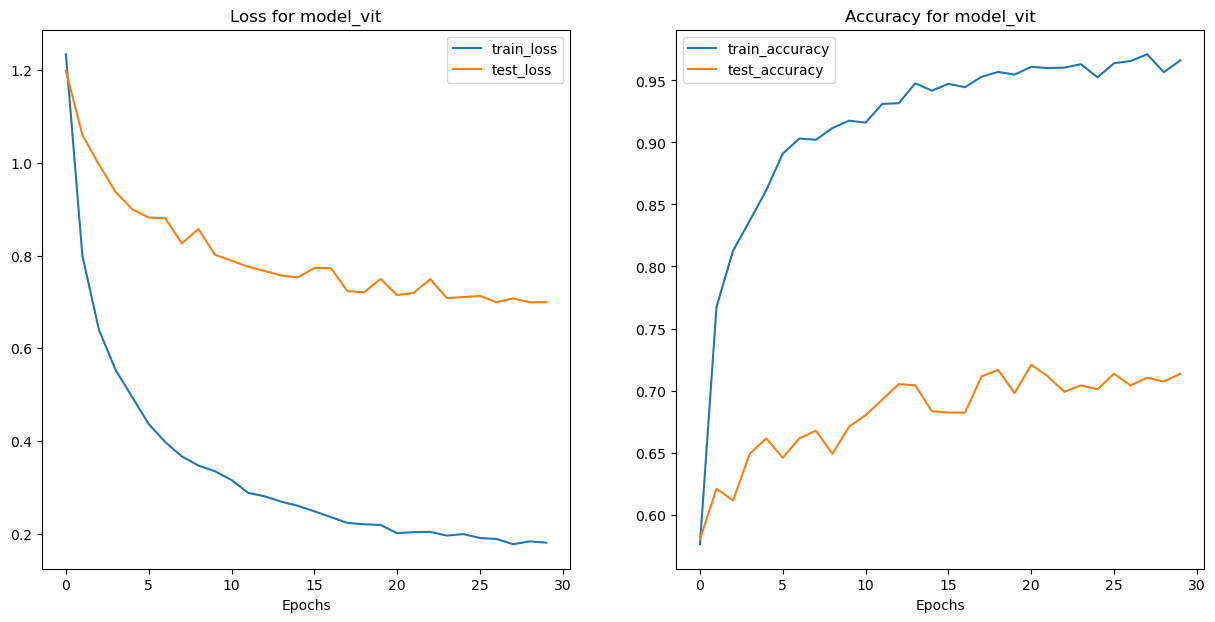

In [18]:
# Plot the loss curves
from implemented_functions_to_use.helper_functions import plot_loss_curves,plot_roc_auc,plot_confusion_matrix
# Plot loss curve
plot_loss_curves('model_vit',model_vit_results)


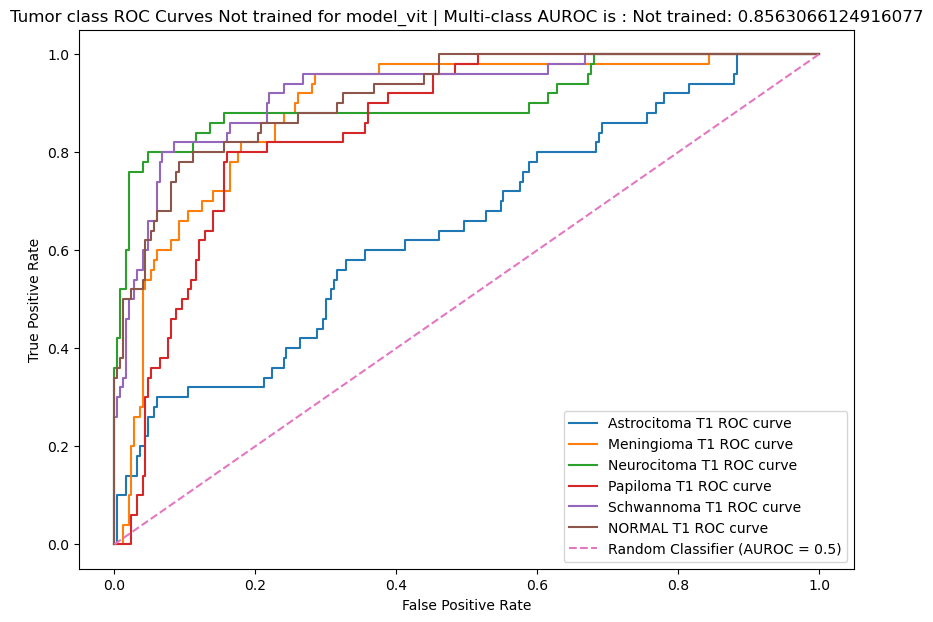

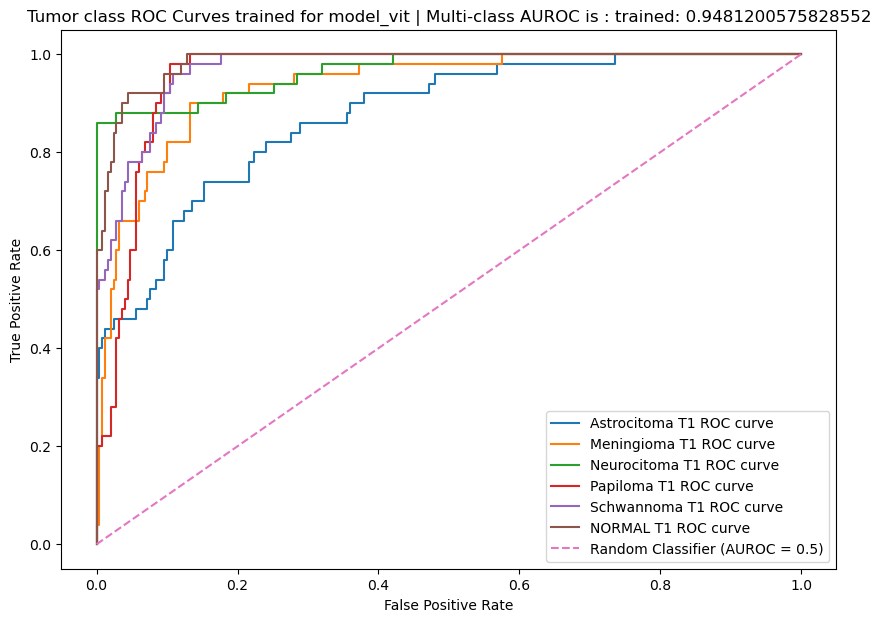

In [19]:
# Plot roc auc
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']
plot_roc_auc('model_vit',model_vit_results,len(class_names),class_names,False)
plot_roc_auc('model_vit',model_vit_results,len(class_names),class_names,True)
# model_vit_results["y_pred"][0].shape